# Time Series Forecasting

## Overview

The Engine provides a simple toolset that allows users to forecast the future behavior of timeseries data using a Trainee.

## Recipe Goals

This recipe will demonstrate how to leverage Howso Engine's time series tools to forecast time-series data.

In [1]:
import os

from IPython.display import display
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

from howso.engine import Trainee
from howso.utilities import infer_feature_attributes

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

## Step 1: Create Data

For this recipe, we use simulated data of a projectile that is launched vertically in the air with a randomly generated initial velocity. Then its height is calculated for each time step as gravity affects the vertical velocity until it hits the ground (height <= 0).

Additionally, we make sure that some of these series end early. We will use these unfinished series to demonstrate the ability to forecast series until their end.

In [2]:
cases = 200
max_initial_velocity = 22
min_initial_velocity = 8
dt = 0.1
gravity = 10

data = []
unfinished_ids = []

for i in range(cases):
    id = i
    dy = min_initial_velocity + np.random.random() * (max_initial_velocity - min_initial_velocity)
    time = 0
    y = 0
    stop_time = 0.75 + np.random.rand() * 2

    while y >= 0:
        data.append([id, time, y])
        dy -= 10 * dt
        y += dy
        time += dt

        if id % 20 == 0 and time > stop_time:
            unfinished_ids.append(id)
            break
    data.append([id, time, y])

df = pd.DataFrame(data, columns=['id', 'time', 'y'])

Here we plot the data. All the finished series are shown in blue and the unfinished series are shown in orange.

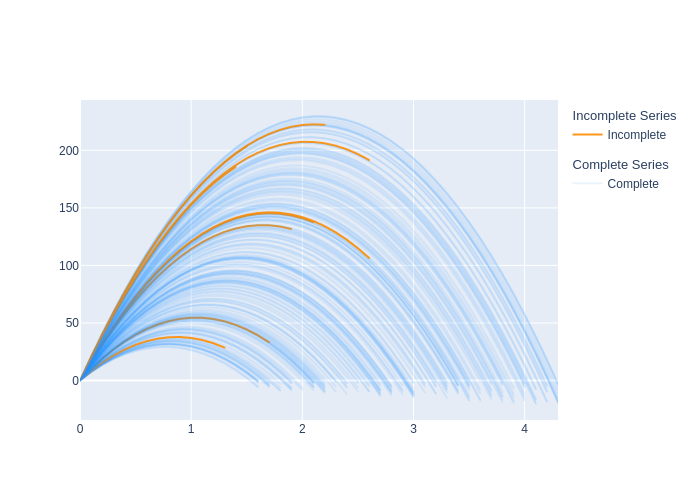

In [3]:
fig = go.Figure()
first_complete, first_incomplete = True, True

for id in df.id.unique():
    if id in unfinished_ids:
        fig.add_trace(go.Scattergl(
            x=df[df.id == id].time,
            y=df[df.id == id].y,
            name="Incomplete",
            mode="lines",
            line_color="darkorange",
            opacity=0.9,
            legendgroup="i",
            legendgrouptitle=dict(text="Incomplete Series"),
            showlegend=first_incomplete,
        ))
        first_incomplete=False
    else:
        fig.add_trace(go.Scattergl(
            x=df[df.id == id].time,
            y=df[df.id == id].y,
            name="Complete",
            mode="lines",
            line_color="dodgerblue",
            opacity=0.1,
            legendgroup="c",
            legendgrouptitle=dict(text="Complete Series"),
            showlegend=first_complete
        ))
        first_complete=False
fig.show()

## Step 2: Define the Feature Attributes

There are a few key steps to defining the feature attributes in this notebook:
- Confirm the data types are detected correctly
- Specify the name of both the series ID feature and the time feature
- Specify the time feature to be **not universal**

One important feature attribute in time-series flows is 'universal'. This attribute can be found within the feature attributes under the "time_series" section of the attributes of the time feature. The attribute is a boolean flag that indicates whether the time feature should be treated as "universal" or not. When the time feature is universal, the Engine will not be able to use **any** data with a time value greater than the the time value of the data being predicted, in other words, it cannot use future data. If the time feature is **not** universal, then the Engine can use all of the data seen in other series, but still cannot use future data from the series it is making a prediction on. When this attribute is unspecified, the default behavior of the Engine is to treat the time feature as if it **is universal**.

The data presented in this notebook uses a time feature that is relative to each series. Each series starts at time 0 and it increases until the series ends. The time value isn't derived from any shared context, so we can set "universal" to be false in this example. In fact, we should do so to improve accuracy. Setting "universal" to false in this setting allows the Engine to leverage more of the trained data, without leaking external information relating to time. This is why we set the 'time_feature_is_universal' flag to false in our call to `infer_feature_attributes`.

In [4]:
# Identify id-feature and time-feature
id_feature_name = "id"
time_feature_name = "time"
features = infer_feature_attributes(
    df,
    time_feature_name=time_feature_name,
    id_feature_name=id_feature_name,
    time_feature_is_universal=False,
)

features.to_dataframe()

type decimal_places     bounds                       data_type  \
                                allow_null       min         max             
id       nominal            NaN      False       NaN         NaN    number   
time  continuous           17.0      False   0.00000    7.389056    number   
y     continuous           17.0       True -54.59815  403.428793    number   

     id_feature original_type      time_series                         \
                    data_type size        type time_feature universal   
id         True       integer    8         NaN          NaN       NaN   
time        NaN       numeric    8       delta         True     False   
y           NaN       numeric    8        rate          NaN       NaN   

                                                                        \
                  delta_max             delta_min             rate_max   
id                      NaN                   NaN                  NaN   
time  [0.27182818284590476]  [0.0367879441171441]                  NaN   
y                       NaN                   NaN  [569.3096352916873]   

                            
                  rate_min  
id                     NaN  
time                   NaN  
y     [-583.1300364751067]

## Step 3: Create the Trainee, Train, and Analyze

The one change between regular analysis using non-time series data and time series data is that during the `train` call, Engine calculates temporal information (deltas and rates) for each feature and adds these values in as additional features in your dataset.

This happens automatically if the feature attributes are configured properly.

In [5]:
t = Trainee(features=features)

# Training on the finished series data
t.train(df[~df.id.isin(unfinished_ids)])
t.analyze()

## Step 4: Forecast the series data

To forecast the series, we will use the 'continue_series' flag as well as the 'continue_series_features' and 'continue_series_values' parameters to specify the series data we would like to forecast.

In [6]:
unfinished_series_df = df[df.id.isin(unfinished_ids)]
continue_series_values = [x[1] for x in unfinished_series_df.groupby('id')]

In [7]:
synth_df = t.react_series(
    series_context_features=['id', 'time', 'y'],
    series_context_values=continue_series_values,
    action_features=['id', 'time', 'y'],
    continue_series=True,
    output_new_series_ids=False,
)['action']

display(synth_df)

,.series,id,time,y
0,series_1,0,2.2,133.032962
1,series_1,0,2.3,127.575863
2,series_1,0,2.4,121.118768
3,series_1,0,2.5,113.661682
4,series_1,0,2.6,105.204608
...,...,...,...,...
139,series_9,180,3.9,62.599492
140,series_9,180,4.0,44.184966
141,series_9,180,4.1,24.770417
142,series_9,180,4.2,4.355833


## Step 5: Inspect the Forecast Data

It's usually helpful to inspect the forecasted data, so let's inspect the visualization of the forecasted data compared to the data that was used to make the forecasts.

We hope to see smooth arcs that simulate the path of the projectile until it hits the ground.

Of course, these forecasts may not be perfect, but we should see the general shape and the series should end near when they reach zero on the Y-axis.

In [8]:
last_cases_original = df.sort_values('time', ascending=False).drop_duplicates(['id'])
synth_df_with_lasts = pd.concat([synth_df, last_cases_original]).sort_values('time', ascending=False)

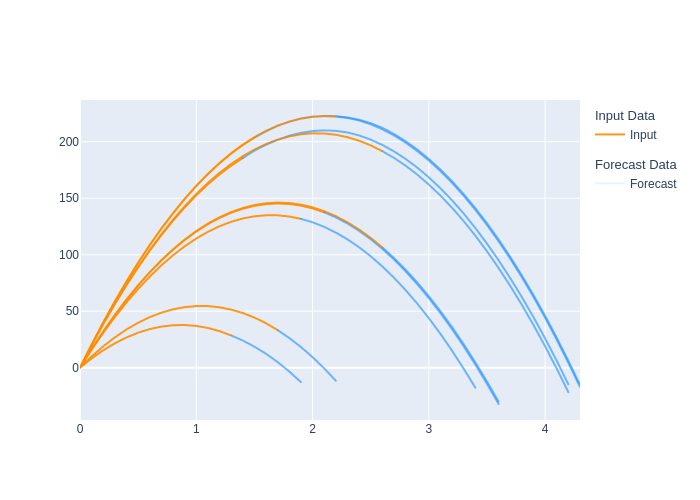

In [9]:
fig = go.Figure()
first_trained = True
first_synthed = True

for id in unfinished_ids:
    fig.add_trace(go.Scattergl(
        x=df[df.id == id].time,
        y=df[df.id == id].y,
        name="Input",
        mode="lines",
        line_color="darkorange",
        opacity=0.9,
        legendgroup="i",
        legendgrouptitle=dict(text="Input Data"),
        showlegend=first_trained
    ))
    first_trained = False

    for id in synth_df_with_lasts.id.unique():
        fig.add_trace(go.Scattergl(
            x=synth_df_with_lasts[synth_df_with_lasts.id == id].time,
            y=synth_df_with_lasts[synth_df_with_lasts.id == id].y,
            name="Forecast",
            mode="lines",
            line_color="dodgerblue",
            opacity=0.1,
            legendgroup="c",
            legendgrouptitle=dict(text="Forecast Data"),
            showlegend=first_synthed
        ))
        first_synthed = False
fig.show()

# Conclusion

In this recipe, we demonstrate how the Howso Engine can be used to forecast time-series data. Importantly, we show how to do a forecast on untrained data using `continue_series` and its related parameters. This recipe also provides generally useful information for any time-series use-case with the Howso Engine.